# Imports & Constants

Let's try not to directly reference colors, fontsizes, opacities in the cells.

Instead, define and use the constants in this cell:

In [1]:
import numpy as np
import dateutil
import itertools
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
        
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

LABEL_FONTSIZE=20
TICK_FONTSIZE=15
ALPHA1 = 0.55
BINS = 21
FIGSIZE1=(7.5, 5)
LEGEND_FACECOLOR = "white"

BLACK='k'
C1, C2, C3, C4, C5, C6 = sns.color_palette()[:6]

# Timestamp Analysis Routines:

In [2]:
def parse_datetime(line):
    if '|' in line:
        line = line.split('|')[0]
    return dateutil.parser.parse(line)

def get_experiment_start_time(experiment_dir):
    """Return the datetime object of when experiment began"""
    with open(Path(experiment_dir).joinpath("experiment_main.log")) as fp:
        line = fp.readline()
        assert "Logging on" in line, f"{line}"
    return parse_datetime(line)

In [3]:
def get_training_times(experiment_dir):
    """Return a list of [(train_start, train_end)] expressed in elapsed seconds."""
    p = Path(experiment_dir)
    if p.joinpath("training.log").is_file():
        return _parse_gpu_train_logs(p.joinpath("training.log"))
    elif p.joinpath("run.log").is_file():
        return _parse_cs1_train_logs(p.joinpath("run.log"))
    elif p.joinpath("cs1_run.log").is_file():
        return _parse_cs1_train_logs(p.joinpath("cs1_run.log"))
    else: 
        raise ValueError("No training log file found")
    
def _parse_cs1_train_logs(p):
    # Training finished with 3276800 samples in 71.159 seconds
    durations = []
    print(f"Parsing CS1 training log: {p}")
    with open(p) as fp:
        for line in fp:
            if "Training finished with" in line:
                assert line.split()[-5] == "seconds,"
                t = float(line.split()[-6])
                durations.append(t)
                
    checkpoint_write_times = []
    t0 = get_experiment_start_time(p.parent)
    for chk in p.parent.joinpath("model_weights").glob("model.ckpt*.index"):
        chk_time = datetime.fromtimestamp(chk.stat().st_mtime)
        chk_time = (chk_time - t0).total_seconds()
        checkpoint_write_times.append(chk_time)
        
    training_time_intervals = [
        (chk_time - t, chk_time) for chk_time, t in zip(sorted(checkpoint_write_times), durations)
    ]
    return training_time_intervals

def _parse_gpu_train_logs(p):
    print(f"Parsing GPU training log: {p}")
    t0 = get_experiment_start_time(p.parent)
    starts = []
    ends = []
    with open(p) as fp:
        for line in fp:
            if "start train" in line:
                starts.append(parse_datetime(line))
            elif "end train" in line:
                ends.append(parse_datetime(line))
            
    training_time_intervals = [
        ((start-t0).total_seconds(), (end-t0).total_seconds()) 
        for start, end in zip(starts, ends)
    ]
    return training_time_intervals

In [4]:
def _get_lof_internal_timings(experiment_dir):
    # Outlier detection:
    # start model prediction with weights (begin fwd pass)
    # end model prediction (end of fwd pass)

    # Starting outlier searching (start of LOF)
    # Done with outlier searching (end of LOF)

    # Sending new outlier pdbs to (start of IO)
    # Finished sending new outliers (end of IO)
    fwd_pass_times = [[], []]
    lof_times = [[], []]
    io_times = [[], []]
    
    with open(Path(experiment_dir).joinpath('outlier_detection.log')) as fp:
        for line in fp:
            if "start model prediction with weights" in line:
                fwd_pass_times[0].append(parse_datetime(line))
            elif "end model prediction" in line:
                fwd_pass_times[1].append(parse_datetime(line))
            elif "Starting outlier searching" in line:
                lof_times[0].append(parse_datetime(line))
            elif "Done with outlier searching" in line:
                lof_times[1].append(parse_datetime(line))
            elif "Sending new outlier pdbs" in line:
                io_times[0].append(parse_datetime(line))
            elif "Finished sending new outliers" in line:
                io_times[1].append(parse_datetime(line))              
    t0 = get_experiment_start_time(experiment_dir)
    for item in (fwd_pass_times, lof_times, io_times):
        for dim in (0,1):
            item[dim] = [(t-t0).total_seconds() for t in item[dim]]
    return fwd_pass_times, lof_times, io_times


def get_lof_times(experiment_dir):
    fwd_pass_times, lof_times, io_times = _get_lof_internal_timings(experiment_dir)
    outlier_detection_intervals = list(zip(fwd_pass_times[0], io_times[1]))
    return outlier_detection_intervals

def draw_lof_profile(experiment_dir):
    fwd_pass_times, lof_times, io_times = _get_lof_internal_timings(experiment_dir)
    fwd_pass_durations = [fwd_pass_times[1][i] - fwd_pass_times[0][i] for i in range(len(fwd_pass_times[1]))][1:]
    lof_durations = [lof_times[1][i] - lof_times[0][i] for i in range(len(lof_times[1]))][1:]
    io_durations = [io_times[1][i] - io_times[0][i] for i in range(len(io_times[1]))][1:]
  
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = 'CVAE', 'LOF', 'I/O'
    sizes = [sum(fwd_pass_durations), sum(lof_durations), sum(io_durations)]
    explode = (0, 0.0, 0.05)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

In [5]:
def get_sim_running_count(exp_dir):
    sim_starts, sim_ends = [], []
    print("Scanning md_runs for start/end times (this takes a while...)")
    for fname in Path(exp_dir).joinpath("md_runs").glob("run0???.log"):
        with open(fname) as fp:
            for line in fp:
                if "START sim.step" in line:
                    sim_starts.append(parse_datetime(line))
                elif "END sim.step" in line:
                    sim_ends.append(parse_datetime(line))
                    
    t0 = get_experiment_start_time(exp_dir)
    sim_starts = [(t-t0).total_seconds() for t in sim_starts]
    sim_ends = [(t-t0).total_seconds() for t in sim_ends]
    combined = [(t, 1) for t in sim_starts] + [(t, -1) for t in sim_ends]
    combined = sorted(combined, key = lambda x: x[0])
    #times = [x[0] for x in combined]
    #counts = [x[1] for x in combined]
    times, counts = zip(*combined)
    counts = np.clip(np.cumsum(counts), 0, 160)
    return times, counts

In [6]:
def experiment_timeline(exp_dir):
    train_intervals = get_training_times(exp_dir)
    #print("Training:", train_intervals)
    lof_intervals = get_lof_times(exp_dir)
    #print("LOF:", lof_intervals)
    md_times, md_counts = get_sim_running_count(exp_dir)

    fig = plt.figure(figsize=FIGSIZE1)
    ax = plt.subplot()

    exp_end = max(md_times)/60 + 5
    ax.step([t/60 for t in md_times], md_counts, where='post', label="MD Run Count")

    ax.set_xlabel("Experiment time (minutes)")
    ax.set_ylabel("Running MD Count")
    ax.set_ylim(0, max(md_counts)+10)
    ax.set_xlim(0, exp_end)
    #ax.set_yticks([130,140,150,160])
    
    # These spans are scaled by the width of the canvas:
    for i, (start, end) in enumerate(sorted(train_intervals)):
        ax.axhspan(90, 98, xmin=start/60/exp_end, xmax=end/60/exp_end, color=C2, ec=BLACK)
    for i, (start, end) in enumerate(sorted(lof_intervals)):
        ax.axhspan(80, 86, xmin=start/60/exp_end, xmax=end/60/exp_end, color=C3, ec=BLACK)
    #ax.legend()
    ##ax.legend(bbox_to_anchor=(0.015, 0.99), loc=2, borderaxespad=0., ncol=3, columnspacing=0, labelspacing=-1)

# Timestamp Analyses:

## nsp1016_448_cs1.3

- Training on CS1
- LOF on 1 ThetaGPU node
- 160 MD Runs (1 per GPU on 20 ThetaGPU nodes)

Parsing CS1 training log: /projects/RL-fold/msalim/production-runs/pasc/nsp1016_448_cs1.3/cs1_run.log
Scanning md_runs for start/end times (this takes a while...)


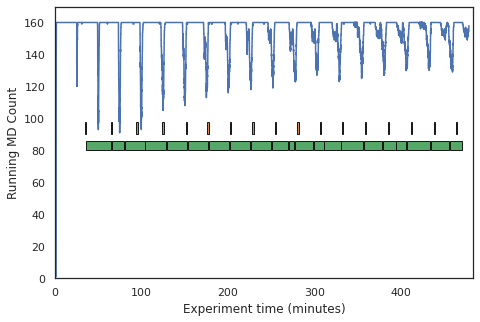

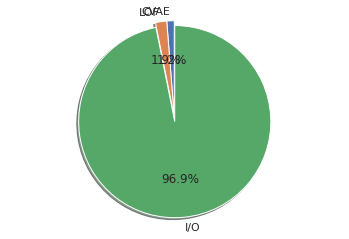

In [7]:
experiment_timeline("/projects/RL-fold/msalim/production-runs/pasc/nsp1016_448_cs1.3/")
draw_lof_profile("/projects/RL-fold/msalim/production-runs/pasc/nsp1016_448_cs1.3/")

## nsp1016_448_gpu.1

- Training on 1 GPU node
- LOF on 1 ThetaGPU node
- 152 MD Runs (1 per GPU on 19 ThetaGPU nodes)

Parsing GPU training log: /projects/RL-fold/msalim/production-runs/pasc/nsp1016_448_gpu.1/training.log
Scanning md_runs for start/end times (this takes a while...)


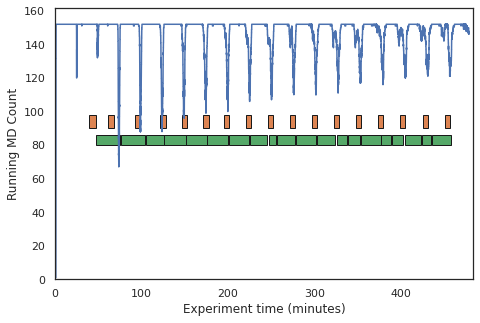

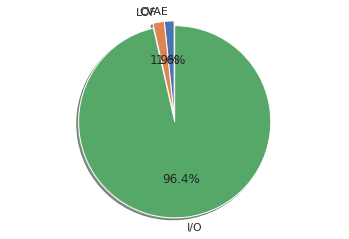

In [8]:
experiment_timeline("/projects/RL-fold/msalim/production-runs/pasc/nsp1016_448_gpu.1/")
draw_lof_profile("/projects/RL-fold/msalim/production-runs/pasc/nsp1016_448_gpu.1/")

## nsp1016_448_gpu.2

- Training on 4 GPU nodes
- LOF on 1 ThetaGPU node
- 128 MD Runs (1 per GPU on 16 ThetaGPU nodes)

Parsing GPU training log: /projects/RL-fold/msalim/production-runs/pasc/nsp1016_448_gpu.2/training.log
Scanning md_runs for start/end times (this takes a while...)


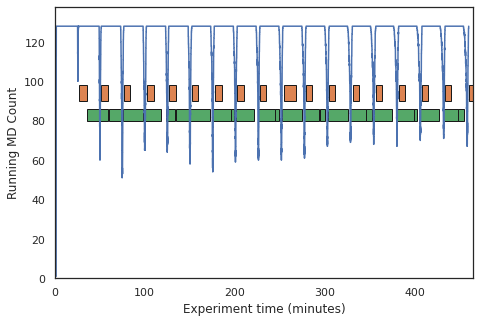

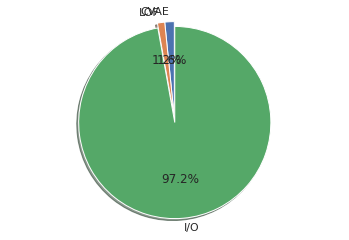

In [111]:
experiment_timeline("/projects/RL-fold/msalim/production-runs/pasc/nsp1016_448_gpu.2/")
draw_lof_profile("/projects/RL-fold/msalim/production-runs/pasc/nsp1016_448_gpu.2/")

## bba_28_gpu.1

- Training on 1 GPU nodes
- LOF on 1 ThetaGPU node
- 152 MD Runs (1 per GPU on 19 ThetaGPU nodes)

Parsing GPU training log: /projects/RL-fold/msalim/production-runs/pasc/bba_28_gpu.1/training.log
Scanning md_runs for start/end times (this takes a while...)


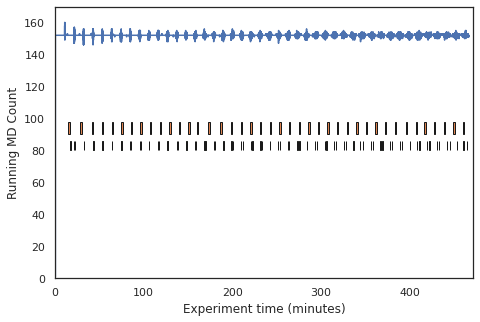

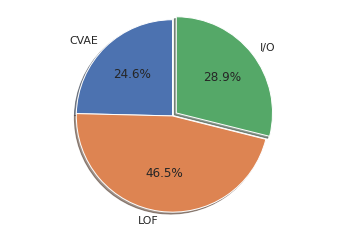

In [113]:
experiment_timeline("/projects/RL-fold/msalim/production-runs/pasc/bba_28_gpu.1/")
draw_lof_profile("/projects/RL-fold/msalim/production-runs/pasc/bba_28_gpu.1/")

# Learning Curve Analysis

In [12]:
def parse_loss(exp_dir):
    p = Path(exp_dir)
    if p.joinpath("training.log").is_file():
        fname = p.joinpath("training.log")
        return _parse_gpu_loss(fname)
    elif p.joinpath("run.log").is_file():
        fname = p.joinpath("run.log")
        return _parse_cs1_loss(fname)
    elif p.joinpath("cs1_run.log").is_file():
        fname = p.joinpath("cs1_run.log")
        return _parse_cs1_loss(fname)
    else:
        raise ValueError("No train log")
        
def _parse_gpu_loss(fname):
    steps, losses, times = [], [], []
    with open(fname) as f:
        for line in f:
            if "loss =" in line:
                tokens = line.split()
                time = parse_datetime(line)
                step = int(tokens[8]) # '32'
                loss = float(tokens[5][:-1]) # '18780.844,
                steps.append(step)
                losses.append(loss)
                times.append(time)
    t0 = times[0]
    assert t0 == min(times)
    times = [(t-t0).total_seconds() for t in times]
    deltas = [times[i+1] - times[i] for i in range(len(times)-1)]
    big_deltas = [(i, d) for i, d in enumerate(deltas) if d > 30]
    for i,d in big_deltas:
        for j in range(i+1, len(times)):
            times[j] -= d
    return steps, losses, times

def _parse_cs1_loss(fname):
    steps, losses, times = [0], [float("inf")], [0]
    steps_per_sec = []
    idx = 1
    with open(fname) as f:
        for line in f:
            if "loss =" in line and "Saving dict" not in line:
                tokens = line.split()
                step = int(tokens[2][:-1]) # '1216:'
                loss = float(tokens[5]) # 4780.0
                per_sec = float(tokens[6][1:])
                time = (step - steps[idx-1]) / per_sec
                #print(f"{step - steps[idx-1]} took {time} sec")
                steps.append(step)
                losses.append(loss)
                times.append(time)
                idx += 1
    times = list(np.cumsum(times))
    return steps, losses, times

In [13]:
def plot_losses(exp_dirs, labels=None, as_time=False):
    fig = plt.figure(figsize=FIGSIZE1)
    ax = plt.subplot()
    
    exps = [parse_loss(d) for d in exp_dirs]
    colors = [C1,C2,C3,C4,C5,C6]
    plt.yscale("log")
    if labels is None: 
        labels = [d.name for d in exp_dirs]
    
    for label, (steps, losses, times), color in zip (labels, exps, colors):
        x_value = [t/60.0 for t in times] if as_time else steps
        ax.plot(x_value, losses, label=label, c=color)
    ax.set_xlabel("Training time / min" if as_time else "Training steps")
    ax.set_ylabel("Training Loss")
    ax.legend(facecolor="white")

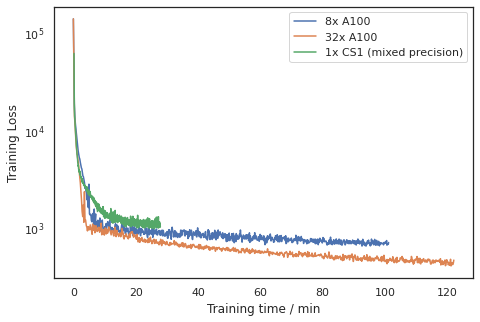

In [15]:
p = Path("/projects/RL-fold/msalim/production-runs/pasc/")
paths = [p/"nsp1016_448_gpu.1", p/"nsp1016_448_gpu.2", p/"nsp1016_448_cs1.3"]
labels = ["8x A100", "32x A100", "1x CS1 (mixed precision)"]
plot_losses(paths, labels=labels, as_time=True)

# Conformational Sampling Analysis:

In [22]:
def plot_conformational_sampling(paths, iterations=[0]):

    # Collect all RMSD from each experiment
    rmsd_files = []
    for path in paths:
        rmsd_files.extend(list(path.joinpath("outlier_runs").glob("rmsds-*")))

    # Sort RMSD files by time of creation
    rmsd_files = sorted(
        rmsd_files, # rmsds-1607655171.npy
        key=lambda p: int(p.with_suffix("").name.split("-")[1])
    )
    
    # Load RMSD arrays into memory
    rmsd_values = [np.load(f.as_posix()) for f in rmsd_files]
    
    # Plot histograms
    for ind, color in zip(
        sorted(iterations),
        itertools.cycle(sns.color_palette()
    )):
        plt.hist(
            rmsd_values[ind],
            bins=BINS,
            label=f"iter-{ind}",
            color=color,
            alpha=ALPHA1,
        )

    plt.legend(facecolor=LEGEND_FACECOLOR)
    plt.xlabel(r'RMSD to reference state $(\AA)$', fontsize=LABEL_FONTSIZE)
    plt.ylabel('Outlier count', fontsize=LABEL_FONTSIZE)
    plt.xticks(fontsize=TICK_FONTSIZE)
    plt.yticks(fontsize=TICK_FONTSIZE)
    #plt.savefig("./rmsd-histograms.png", dpi=600)
    plt.show()

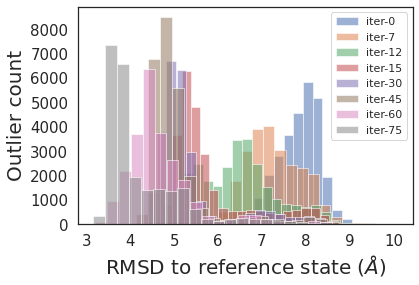

In [23]:
p = Path("/projects/RL-fold/msalim/production-runs/pasc/")
paths = [p/"bba_28_cs1.1"]
iterations = list(range(0, 82, 15)) + [7, 12]
plot_conformational_sampling(paths, iterations)

In [66]:
def kde_conformational_sampling(paths, iterations=[0], labels=None):

    # Collect all RMSD from each experiment
    rmsd_files = []
    for path in paths:
        rmsd_files.extend(list(path.joinpath("outlier_runs").glob("rmsds-*")))

    # Sort RMSD files by time of creation
    rmsd_files = sorted(
        rmsd_files, # rmsds-1607655171.npy
        key=lambda p: int(p.with_suffix("").name.split("-")[1])
    )
    
    # Load RMSD arrays into memory
    rmsd_values = [np.load(f.as_posix()) for f in rmsd_files]
    
    # Plot KDEs
    iterations = sorted(iterations)
    if labels is None:
        labels = [f"iter-{ind}" for ind in iterations]
    data = {label: rmsd_values[ind] for (label, ind) in zip(labels, iterations)}
        
    sns.displot(data, kind="kde", palette="icefire", bw_adjust=0.1, fill=True)
    plt.xlabel(r'RMSD to reference state $(\AA)$', fontsize=LABEL_FONTSIZE)
    plt.ylabel('Outlier density', fontsize=LABEL_FONTSIZE)
    #plt.savefig("./rmsd-histograms.png", dpi=600)
    plt.show()

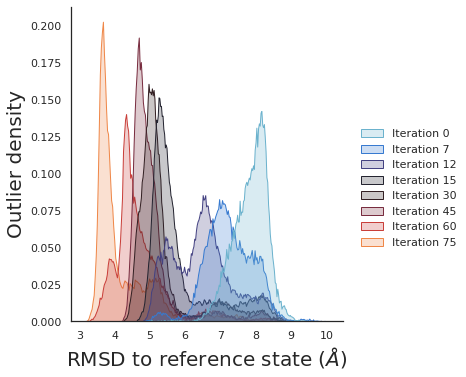

In [69]:
p = Path("/projects/RL-fold/msalim/production-runs/pasc/")
paths = [p/"bba_28_cs1.1"]
iterations = list(range(0, 82, 15)) + [7, 12]
kde_conformational_sampling(paths, iterations, labels=[f"Iteration {i}" for i in sorted(iterations)])

In [81]:
def kde_run_comparison(paths, iteration, labels=None):
    # Collect all RMSD from each experiment
    rmsd_file = {}
    rmsd_values = {}
    for path in paths:
        print(path)
        rmsd_file[path] = sorted(
            list(path.joinpath("outlier_runs").glob("rmsds-*")),
            key=lambda p: int(p.with_suffix("").name.split("-")[1])
        )[iteration]

    
    # Load RMSD arrays into memory
    if labels is None:
        labels = [p.name for p in paths]
    for path, label in zip(paths, labels):
        rmsd_values[label] = np.load(rmsd_file[path].as_posix())
        
    sns.displot(rmsd_values, kind="kde", palette="icefire", bw_adjust=1, fill=True)
    plt.xlabel(r'RMSD to reference state $(\AA)$', fontsize=LABEL_FONTSIZE)
    plt.ylabel('Outlier density', fontsize=LABEL_FONTSIZE)
    #plt.savefig("./rmsd-histograms.png", dpi=600)
    plt.show()

/projects/RL-fold/msalim/production-runs/pasc/nsp1016_448_gpu.1
/projects/RL-fold/msalim/production-runs/pasc/nsp1016_448_gpu.2


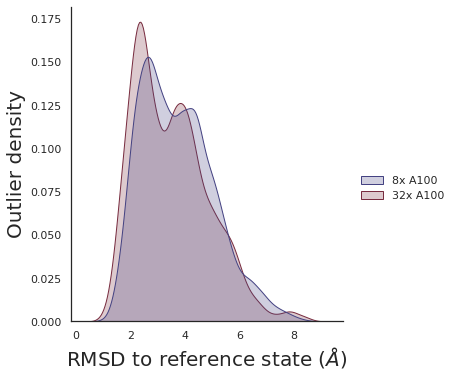

/projects/RL-fold/msalim/production-runs/pasc/nsp1016_448_gpu.1
/projects/RL-fold/msalim/production-runs/pasc/nsp1016_448_gpu.2


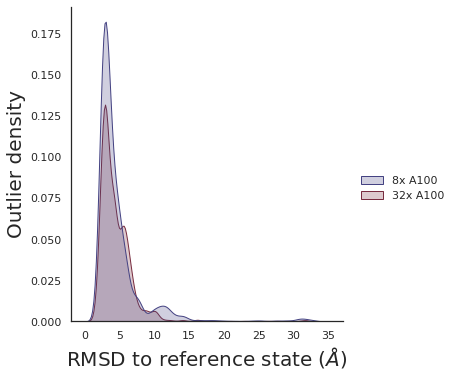

In [82]:
p = Path("/projects/RL-fold/msalim/production-runs/pasc/")
paths = [p/"nsp1016_448_gpu.1", p/"nsp1016_448_gpu.2"]
kde_run_comparison(paths, iteration=0, labels=["8x A100", "32x A100"])
kde_run_comparison(paths, iteration=-1, labels=["8x A100", "32x A100"])